# 10. 形态点位
*盘整形态是等待趋势的机会*

## 目录
1. 什么是形态?
2. 如何找到高低转折点？
3. 各种形态的计算条件是什么？
4. 如何把形态用图展示出来？
5. 如何将形态编写成策略？

## 什么是形态?
价格形态的变化往往预示着上升趋势和下降趋势之间的转变。根据定义，价格形态是一种可识别的价格变动结构，通过一系列趋势线或曲线来确定。当价格形态显示趋势方向的变化时，它被称为反转模式;当趋势在短暂停顿后继续存在时，就会出现持续模式。长期以来，技术分析师一直使用价格形态来检验当前的走势，并预测未来的市场走势。

## 如何找到高低转折点？
通过当两条EMA发生金叉，就往回一段时间（10天）找最低点。
通过当两条EMA发生死叉，就往回一段时间（10天）找最高点。

In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
from jaqs_fxdayu.data.hf_dataview import HFDataView

dv = HFDataView()

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime

def resampleData(data, period='1H'):
    data['time'] = pd.Index(map(lambda x : datetime.strptime(x, "%Y-%m-%d %H:%M:%S") , data_excel['time']))
    data_time = data.set_index('time').dropna()
    dataResample = data_time.resample(period).agg({'high':'max','open':'first','close':'last','low':'min','volume':'sum','amount':'sum'}).dropna()
    return dataResample

data_excel = pd.read_csv(r'E:\2018_Course\AnalysisTool\HFD\bch_usdt.csv').iloc[:,1:]
data1H = resampleData(data_excel, period='1H')

In [4]:
data1H.head()

,high,open,close,low,volume,amount
time,,,,,,
2017-12-31 16:00:00,2455.6799,2420.4900,2452.9697,2411.9836,1147.715204,1.820919e+07
2018-01-01 16:00:00,2303.6766,2303.6766,2273.8099,2265.8602,254.614591,3.787647e+06
2018-01-01 17:00:00,2290.7398,2279.2501,2281.7337,2259.0320,373.646454,5.535485e+06
2018-01-01 18:00:00,2306.0192,2279.3903,2288.9201,2270.3300,157.693605,2.356792e+06
2018-01-01 19:00:00,2295.2503,2286.3300,2295.2503,2279.4240,128.658808,1.913306e+06


In [5]:
def initDv(data):
    data['time'] = data.index
    data["trade_date"] = data["time"].apply(lambda x:int(x.strftime(format="%Y-%m-%d %H:%M:%S").replace("-","").replace(":","").replace(" ","")))
    data["symbol"] = "btc_usdt"
    data['usdt'] = 6.8
    data = data.set_index(["trade_date","symbol"])
    dv.create_init_dv(data) # 用来初始化dv
dataDv = data1H.copy()
initDv(dataDv)

Initialize dataview success.


## 信号计算

In [6]:
import talib as ta

data1H['EMA2'] = ta.abstract.EMA(data1H, 2)
data1H['EMA5'] = ta.abstract.EMA(data1H, 5)

In [7]:
def low_rolling(frame):
    if frame['EMA2'][-1] > frame["EMA5"][-1] and (frame['EMA2'][-2] < frame["EMA5"][-2]):
        return frame['low'].idxmin(), frame['low'].min()  
    else:
        return None

def high_rolling(frame):
    print(frame['EMA2'])
    if frame['EMA2'][-1] < frame["EMA5"][-1] and (frame['EMA2'][-2] > frame["EMA5"][-2]):
        return frame['high'].idxmax(), frame['high'].max()
    else:
        return None

def rolling(data, function, window=10):
    for i in range(window, len(data)):
        value = function(data.iloc[i-window: i])
        if value:
            yield value #把方法编程生成器，可以用for循环

In [8]:
high_dict = dict(rolling(data1H, high_rolling))
low_dict = dict(rolling(data1H, low_rolling))

time
2017-12-31 16:00:00            NaN
2018-01-01 16:00:00    2363.389800
2018-01-01 17:00:00    2308.952400
2018-01-01 18:00:00    2295.597533
2018-01-01 19:00:00    2295.366044
2018-01-01 20:00:00    2316.108681
2018-01-01 21:00:00    2329.950560
2018-01-01 22:00:00    2333.121653
2018-01-01 23:00:00    2315.641884
2018-01-02 00:00:00    2353.111961
Name: EMA2, dtype: float64
time
2018-01-01 16:00:00    2363.389800
2018-01-01 17:00:00    2308.952400
2018-01-01 18:00:00    2295.597533
2018-01-01 19:00:00    2295.366044
2018-01-01 20:00:00    2316.108681
2018-01-01 21:00:00    2329.950560
2018-01-01 22:00:00    2333.121653
2018-01-01 23:00:00    2315.641884
2018-01-02 00:00:00    2353.111961
2018-01-02 01:00:00    2354.164054
Name: EMA2, dtype: float64
time
2018-01-01 17:00:00    2308.952400
2018-01-01 18:00:00    2295.597533
2018-01-01 19:00:00    2295.366044
2018-01-01 20:00:00    2316.108681
2018-01-01 21:00:00    2329.950560
2018-01-01 22:00:00    2333.121653
2018-01-01 23:00:00  

time
2018-01-11 05:00:00    2429.987259
2018-01-11 16:00:00    2560.337953
2018-01-11 17:00:00    2582.179384
2018-01-11 18:00:00    2561.525928
2018-01-11 19:00:00    2528.641976
2018-01-11 20:00:00    2508.158659
2018-01-11 21:00:00    2473.846353
2018-01-11 22:00:00    2466.486118
2018-01-11 23:00:00    2444.452239
2018-01-12 00:00:00    2409.648280
Name: EMA2, dtype: float64
time
2018-01-11 16:00:00    2560.337953
2018-01-11 17:00:00    2582.179384
2018-01-11 18:00:00    2561.525928
2018-01-11 19:00:00    2528.641976
2018-01-11 20:00:00    2508.158659
2018-01-11 21:00:00    2473.846353
2018-01-11 22:00:00    2466.486118
2018-01-11 23:00:00    2444.452239
2018-01-12 00:00:00    2409.648280
2018-01-12 01:00:00    2428.639227
Name: EMA2, dtype: float64
time
2018-01-11 17:00:00    2582.179384
2018-01-11 18:00:00    2561.525928
2018-01-11 19:00:00    2528.641976
2018-01-11 20:00:00    2508.158659
2018-01-11 21:00:00    2473.846353
2018-01-11 22:00:00    2466.486118
2018-01-11 23:00:00  

time
2018-01-19 20:00:00    1747.658148
2018-01-19 21:00:00    1743.802583
2018-01-19 22:00:00    1738.146928
2018-01-19 23:00:00    1745.538976
2018-01-20 00:00:00    1764.042659
2018-01-20 01:00:00    1776.727420
2018-01-20 02:00:00    1790.022407
2018-01-20 03:00:00    1799.334069
2018-01-20 04:00:00    1823.111290
2018-01-20 05:00:00    1864.315963
Name: EMA2, dtype: float64
time
2018-01-19 21:00:00    1743.802583
2018-01-19 22:00:00    1738.146928
2018-01-19 23:00:00    1745.538976
2018-01-20 00:00:00    1764.042659
2018-01-20 01:00:00    1776.727420
2018-01-20 02:00:00    1790.022407
2018-01-20 03:00:00    1799.334069
2018-01-20 04:00:00    1823.111290
2018-01-20 05:00:00    1864.315963
2018-01-20 06:00:00    1867.874588
Name: EMA2, dtype: float64
time
2018-01-19 22:00:00    1738.146928
2018-01-19 23:00:00    1745.538976
2018-01-20 00:00:00    1764.042659
2018-01-20 01:00:00    1776.727420
2018-01-20 02:00:00    1790.022407
2018-01-20 03:00:00    1799.334069
2018-01-20 04:00:00  

time
2018-01-28 15:00:00    1725.953345
2018-01-28 16:00:00    1730.951182
2018-01-28 17:00:00    1728.201927
2018-01-28 18:00:00    1736.799176
2018-01-28 19:00:00    1746.913125
2018-01-28 20:00:00    1756.345508
2018-01-28 21:00:00    1757.715103
2018-01-28 22:00:00    1764.066368
2018-01-28 23:00:00    1761.373723
2018-01-29 00:00:00    1768.785508
Name: EMA2, dtype: float64
time
2018-01-28 16:00:00    1730.951182
2018-01-28 17:00:00    1728.201927
2018-01-28 18:00:00    1736.799176
2018-01-28 19:00:00    1746.913125
2018-01-28 20:00:00    1756.345508
2018-01-28 21:00:00    1757.715103
2018-01-28 22:00:00    1764.066368
2018-01-28 23:00:00    1761.373723
2018-01-29 00:00:00    1768.785508
2018-01-29 01:00:00    1729.106169
Name: EMA2, dtype: float64
time
2018-01-28 17:00:00    1728.201927
2018-01-28 18:00:00    1736.799176
2018-01-28 19:00:00    1746.913125
2018-01-28 20:00:00    1756.345508
2018-01-28 21:00:00    1757.715103
2018-01-28 22:00:00    1764.066368
2018-01-28 23:00:00  

time
2018-02-05 04:00:00    1130.728996
2018-02-05 05:00:00    1130.242999
2018-02-05 06:00:00    1115.247666
2018-02-05 07:00:00    1088.462555
2018-02-05 08:00:00    1061.487518
2018-02-05 09:00:00    1057.840506
2018-02-05 10:00:00    1031.740169
2018-02-05 11:00:00    1005.281056
2018-02-05 12:00:00    1017.962019
2018-02-05 13:00:00    1013.881940
Name: EMA2, dtype: float64
time
2018-02-05 05:00:00    1130.242999
2018-02-05 06:00:00    1115.247666
2018-02-05 07:00:00    1088.462555
2018-02-05 08:00:00    1061.487518
2018-02-05 09:00:00    1057.840506
2018-02-05 10:00:00    1031.740169
2018-02-05 11:00:00    1005.281056
2018-02-05 12:00:00    1017.962019
2018-02-05 13:00:00    1013.881940
2018-02-05 14:00:00     984.327313
Name: EMA2, dtype: float64
time
2018-02-05 06:00:00    1115.247666
2018-02-05 07:00:00    1088.462555
2018-02-05 08:00:00    1061.487518
2018-02-05 09:00:00    1057.840506
2018-02-05 10:00:00    1031.740169
2018-02-05 11:00:00    1005.281056
2018-02-05 12:00:00  

Name: EMA2, dtype: float64
time
2018-02-12 10:00:00    1290.722148
2018-02-12 11:00:00    1271.240716
2018-02-12 12:00:00    1269.746905
2018-02-12 13:00:00    1264.820902
2018-02-12 14:00:00    1249.606967
2018-02-12 15:00:00    1252.008056
2018-02-12 16:00:00    1254.669352
2018-02-12 17:00:00    1255.556451
2018-02-12 18:00:00    1255.553017
2018-02-12 19:00:00    1265.204272
Name: EMA2, dtype: float64
time
2018-02-12 11:00:00    1271.240716
2018-02-12 12:00:00    1269.746905
2018-02-12 13:00:00    1264.820902
2018-02-12 14:00:00    1249.606967
2018-02-12 15:00:00    1252.008056
2018-02-12 16:00:00    1254.669352
2018-02-12 17:00:00    1255.556451
2018-02-12 18:00:00    1255.553017
2018-02-12 19:00:00    1265.204272
2018-02-12 20:00:00    1272.774824
Name: EMA2, dtype: float64
time
2018-02-12 12:00:00    1269.746905
2018-02-12 13:00:00    1264.820902
2018-02-12 14:00:00    1249.606967
2018-02-12 15:00:00    1252.008056
2018-02-12 16:00:00    1254.669352
2018-02-12 17:00:00    1255.5

Name: EMA2, dtype: float64
time
2018-02-20 00:00:00    1538.518937
2018-02-20 01:00:00    1529.962979
2018-02-20 02:00:00    1526.254326
2018-02-20 03:00:00    1522.084775
2018-02-20 04:00:00    1525.887925
2018-02-20 05:00:00    1515.295975
2018-02-20 06:00:00    1537.765325
2018-02-20 07:00:00    1535.921775
2018-02-20 08:00:00    1517.573925
2018-02-20 09:00:00    1505.857975
Name: EMA2, dtype: float64
time
2018-02-20 01:00:00    1529.962979
2018-02-20 02:00:00    1526.254326
2018-02-20 03:00:00    1522.084775
2018-02-20 04:00:00    1525.887925
2018-02-20 05:00:00    1515.295975
2018-02-20 06:00:00    1537.765325
2018-02-20 07:00:00    1535.921775
2018-02-20 08:00:00    1517.573925
2018-02-20 09:00:00    1505.857975
2018-02-20 10:00:00    1502.619392
Name: EMA2, dtype: float64
time
2018-02-20 02:00:00    1526.254326
2018-02-20 03:00:00    1522.084775
2018-02-20 04:00:00    1525.887925
2018-02-20 05:00:00    1515.295975
2018-02-20 06:00:00    1537.765325
2018-02-20 07:00:00    1535.9

Name: EMA2, dtype: float64
time
2018-02-27 13:00:00    1281.640521
2018-02-27 14:00:00    1264.803774
2018-02-27 15:00:00    1249.567925
2018-02-27 16:00:00    1244.489242
2018-02-28 16:00:00    1219.516414
2018-02-28 17:00:00    1211.971538
2018-02-28 18:00:00    1215.723646
2018-02-28 19:00:00    1221.174549
2018-02-28 20:00:00    1232.349850
2018-02-28 21:00:00    1228.416483
Name: EMA2, dtype: float64
time
2018-02-27 14:00:00    1264.803774
2018-02-27 15:00:00    1249.567925
2018-02-27 16:00:00    1244.489242
2018-02-28 16:00:00    1219.516414
2018-02-28 17:00:00    1211.971538
2018-02-28 18:00:00    1215.723646
2018-02-28 19:00:00    1221.174549
2018-02-28 20:00:00    1232.349850
2018-02-28 21:00:00    1228.416483
2018-02-28 22:00:00    1217.226628
Name: EMA2, dtype: float64
time
2018-02-27 15:00:00    1249.567925
2018-02-27 16:00:00    1244.489242
2018-02-28 16:00:00    1219.516414
2018-02-28 17:00:00    1211.971538
2018-02-28 18:00:00    1215.723646
2018-02-28 19:00:00    1221.1

time
2018-03-08 04:00:00    1049.037975
2018-03-08 05:00:00    1079.371792
2018-03-08 06:00:00    1074.103331
2018-03-08 07:00:00    1083.521310
2018-03-08 08:00:00    1085.913703
2018-03-08 09:00:00    1096.719368
2018-03-08 10:00:00    1094.419856
2018-03-08 11:00:00    1089.557152
2018-03-08 12:00:00    1074.585717
2018-03-08 13:00:00    1075.528572
Name: EMA2, dtype: float64
time
2018-03-08 05:00:00    1079.371792
2018-03-08 06:00:00    1074.103331
2018-03-08 07:00:00    1083.521310
2018-03-08 08:00:00    1085.913703
2018-03-08 09:00:00    1096.719368
2018-03-08 10:00:00    1094.419856
2018-03-08 11:00:00    1089.557152
2018-03-08 12:00:00    1074.585717
2018-03-08 13:00:00    1075.528572
2018-03-08 14:00:00    1078.914524
Name: EMA2, dtype: float64
time
2018-03-08 06:00:00    1074.103331
2018-03-08 07:00:00    1083.521310
2018-03-08 08:00:00    1085.913703
2018-03-08 09:00:00    1096.719368
2018-03-08 10:00:00    1094.419856
2018-03-08 11:00:00    1089.557152
2018-03-08 12:00:00  

Name: EMA2, dtype: float64
time
2018-03-16 23:00:00    983.501502
2018-03-17 00:00:00    984.500501
2018-03-17 01:00:00    972.670234
2018-03-17 02:00:00    974.529545
2018-03-17 03:00:00    971.046515
2018-03-17 04:00:00    976.075505
2018-03-17 05:00:00    972.685168
2018-03-17 06:00:00    974.901723
2018-03-17 07:00:00    975.400841
2018-03-17 08:00:00    996.722947
Name: EMA2, dtype: float64
time
2018-03-17 00:00:00     984.500501
2018-03-17 01:00:00     972.670234
2018-03-17 02:00:00     974.529545
2018-03-17 03:00:00     971.046515
2018-03-17 04:00:00     976.075505
2018-03-17 05:00:00     972.685168
2018-03-17 06:00:00     974.901723
2018-03-17 07:00:00     975.400841
2018-03-17 08:00:00     996.722947
2018-03-17 09:00:00    1016.234316
Name: EMA2, dtype: float64
time
2018-03-17 01:00:00     972.670234
2018-03-17 02:00:00     974.529545
2018-03-17 03:00:00     971.046515
2018-03-17 04:00:00     976.075505
2018-03-17 05:00:00     972.685168
2018-03-17 06:00:00     974.901723
2018

time
2018-03-24 05:00:00    1014.784617
2018-03-24 06:00:00    1012.428006
2018-03-24 07:00:00    1013.178869
2018-03-24 08:00:00    1011.392956
2018-03-24 09:00:00    1008.831119
2018-03-24 10:00:00    1000.512373
2018-03-24 11:00:00     996.107058
2018-03-24 12:00:00    1007.388286
2018-03-24 13:00:00    1009.229429
2018-03-24 14:00:00    1014.046210
Name: EMA2, dtype: float64
time
2018-03-24 06:00:00    1012.428006
2018-03-24 07:00:00    1013.178869
2018-03-24 08:00:00    1011.392956
2018-03-24 09:00:00    1008.831119
2018-03-24 10:00:00    1000.512373
2018-03-24 11:00:00     996.107058
2018-03-24 12:00:00    1007.388286
2018-03-24 13:00:00    1009.229429
2018-03-24 14:00:00    1014.046210
2018-03-24 15:00:00    1018.758803
Name: EMA2, dtype: float64
time
2018-03-24 07:00:00    1013.178869
2018-03-24 08:00:00    1011.392956
2018-03-24 09:00:00    1008.831119
2018-03-24 10:00:00    1000.512373
2018-03-24 11:00:00     996.107058
2018-03-24 12:00:00    1007.388286
2018-03-24 13:00:00  

time
2018-04-02 03:00:00    660.441541
2018-04-02 04:00:00    658.314047
2018-04-02 05:00:00    658.554616
2018-04-02 06:00:00    659.532072
2018-04-02 07:00:00    670.911357
2018-04-02 08:00:00    674.347919
2018-04-02 09:00:00    675.316706
2018-04-02 10:00:00    676.486969
2018-04-02 11:00:00    678.571256
2018-04-02 12:00:00    672.023285
Name: EMA2, dtype: float64
time
2018-04-02 04:00:00    658.314047
2018-04-02 05:00:00    658.554616
2018-04-02 06:00:00    659.532072
2018-04-02 07:00:00    670.911357
2018-04-02 08:00:00    674.347919
2018-04-02 09:00:00    675.316706
2018-04-02 10:00:00    676.486969
2018-04-02 11:00:00    678.571256
2018-04-02 12:00:00    672.023285
2018-04-02 13:00:00    668.597495
Name: EMA2, dtype: float64
time
2018-04-02 05:00:00    658.554616
2018-04-02 06:00:00    659.532072
2018-04-02 07:00:00    670.911357
2018-04-02 08:00:00    674.347919
2018-04-02 09:00:00    675.316706
2018-04-02 10:00:00    676.486969
2018-04-02 11:00:00    678.571256
2018-04-02 12

time
2018-04-09 22:00:00    631.043201
2018-04-09 23:00:00    634.210800
2018-04-10 00:00:00    635.513600
2018-04-10 01:00:00    634.190667
2018-04-10 02:00:00    635.606956
2018-04-10 03:00:00    639.202319
2018-04-10 04:00:00    638.997440
2018-04-10 05:00:00    638.379080
2018-04-10 06:00:00    633.571560
2018-04-10 07:00:00    632.569053
Name: EMA2, dtype: float64
time
2018-04-09 23:00:00    634.210800
2018-04-10 00:00:00    635.513600
2018-04-10 01:00:00    634.190667
2018-04-10 02:00:00    635.606956
2018-04-10 03:00:00    639.202319
2018-04-10 04:00:00    638.997440
2018-04-10 05:00:00    638.379080
2018-04-10 06:00:00    633.571560
2018-04-10 07:00:00    632.569053
2018-04-10 08:00:00    633.056351
Name: EMA2, dtype: float64
time
2018-04-10 00:00:00    635.513600
2018-04-10 01:00:00    634.190667
2018-04-10 02:00:00    635.606956
2018-04-10 03:00:00    639.202319
2018-04-10 04:00:00    638.997440
2018-04-10 05:00:00    638.379080
2018-04-10 06:00:00    633.571560
2018-04-10 07

time
2018-04-17 14:00:00    779.762226
2018-04-17 15:00:00    776.712009
2018-04-17 16:00:00    779.480403
2018-04-17 17:00:00    779.590001
2018-04-17 18:00:00    769.350867
2018-04-17 19:00:00    760.894756
2018-04-17 20:00:00    759.876719
2018-04-17 21:00:00    761.788906
2018-04-17 22:00:00    761.681235
2018-04-17 23:00:00    758.138545
Name: EMA2, dtype: float64
time
2018-04-17 15:00:00    776.712009
2018-04-17 16:00:00    779.480403
2018-04-17 17:00:00    779.590001
2018-04-17 18:00:00    769.350867
2018-04-17 19:00:00    760.894756
2018-04-17 20:00:00    759.876719
2018-04-17 21:00:00    761.788906
2018-04-17 22:00:00    761.681235
2018-04-17 23:00:00    758.138545
2018-04-18 00:00:00    759.981182
Name: EMA2, dtype: float64
time
2018-04-17 16:00:00    779.480403
2018-04-17 17:00:00    779.590001
2018-04-17 18:00:00    769.350867
2018-04-17 19:00:00    760.894756
2018-04-17 20:00:00    759.876719
2018-04-17 21:00:00    761.788906
2018-04-17 22:00:00    761.681235
2018-04-17 23

Name: EMA2, dtype: float64
time
2018-04-25 04:00:00    1297.083582
2018-04-25 05:00:00    1308.939927
2018-04-25 06:00:00    1345.988242
2018-04-25 07:00:00    1344.018281
2018-04-25 08:00:00    1310.556227
2018-04-25 09:00:00    1313.851942
2018-04-25 10:00:00    1288.796714
2018-04-25 11:00:00    1298.185705
2018-04-25 12:00:00    1296.728568
2018-04-25 13:00:00    1285.068389
Name: EMA2, dtype: float64
time
2018-04-25 05:00:00    1308.939927
2018-04-25 06:00:00    1345.988242
2018-04-25 07:00:00    1344.018281
2018-04-25 08:00:00    1310.556227
2018-04-25 09:00:00    1313.851942
2018-04-25 10:00:00    1288.796714
2018-04-25 11:00:00    1298.185705
2018-04-25 12:00:00    1296.728568
2018-04-25 13:00:00    1285.068389
2018-04-25 14:00:00    1278.797396
Name: EMA2, dtype: float64
time
2018-04-25 06:00:00    1345.988242
2018-04-25 07:00:00    1344.018281
2018-04-25 08:00:00    1310.556227
2018-04-25 09:00:00    1313.851942
2018-04-25 10:00:00    1288.796714
2018-04-25 11:00:00    1298.1

Name: EMA2, dtype: float64
time
2018-05-05 09:00:00    1642.475179
2018-05-05 10:00:00    1660.758393
2018-05-05 11:00:00    1666.852798
2018-05-05 12:00:00    1706.171533
2018-05-05 13:00:00    1693.524444
2018-05-05 14:00:00    1711.108148
2018-05-05 15:00:00    1699.915049
2018-05-05 16:00:00    1696.963483
2018-05-05 17:00:00    1691.289428
2018-05-05 18:00:00    1688.374943
Name: EMA2, dtype: float64
time
2018-05-05 10:00:00    1660.758393
2018-05-05 11:00:00    1666.852798
2018-05-05 12:00:00    1706.171533
2018-05-05 13:00:00    1693.524444
2018-05-05 14:00:00    1711.108148
2018-05-05 15:00:00    1699.915049
2018-05-05 16:00:00    1696.963483
2018-05-05 17:00:00    1691.289428
2018-05-05 18:00:00    1688.374943
2018-05-05 19:00:00    1681.813248
Name: EMA2, dtype: float64
time
2018-05-05 11:00:00    1666.852798
2018-05-05 12:00:00    1706.171533
2018-05-05 13:00:00    1693.524444
2018-05-05 14:00:00    1711.108148
2018-05-05 15:00:00    1699.915049
2018-05-05 16:00:00    1696.9

Name: EMA2, dtype: float64
time
2018-05-13 00:00:00    1431.204236
2018-05-13 01:00:00    1431.268079
2018-05-13 02:00:00    1428.395293
2018-05-13 03:00:00    1433.331764
2018-05-13 04:00:00    1416.554655
2018-05-13 05:00:00    1413.724485
2018-05-13 06:00:00    1425.380295
2018-05-13 07:00:00    1428.460098
2018-05-13 08:00:00    1423.643366
2018-05-13 09:00:00    1450.029189
Name: EMA2, dtype: float64
time
2018-05-13 01:00:00    1431.268079
2018-05-13 02:00:00    1428.395293
2018-05-13 03:00:00    1433.331764
2018-05-13 04:00:00    1416.554655
2018-05-13 05:00:00    1413.724485
2018-05-13 06:00:00    1425.380295
2018-05-13 07:00:00    1428.460098
2018-05-13 08:00:00    1423.643366
2018-05-13 09:00:00    1450.029189
2018-05-13 10:00:00    1447.609663
Name: EMA2, dtype: float64
time
2018-05-13 02:00:00    1428.395293
2018-05-13 03:00:00    1433.331764
2018-05-13 04:00:00    1416.554655
2018-05-13 05:00:00    1413.724485
2018-05-13 06:00:00    1425.380295
2018-05-13 07:00:00    1428.4

Name: EMA2, dtype: float64
time
2018-05-21 08:00:00    1266.526274
2018-05-21 09:00:00    1259.842091
2018-05-21 10:00:00    1246.386030
2018-05-21 11:00:00    1245.733877
2018-05-21 12:00:00    1247.251026
2018-05-21 13:00:00    1248.944142
2018-05-21 14:00:00    1231.371514
2018-05-21 15:00:00    1225.180771
2018-05-21 16:00:00    1221.861990
2018-05-21 17:00:00    1219.644663
Name: EMA2, dtype: float64
time
2018-05-21 09:00:00    1259.842091
2018-05-21 10:00:00    1246.386030
2018-05-21 11:00:00    1245.733877
2018-05-21 12:00:00    1247.251026
2018-05-21 13:00:00    1248.944142
2018-05-21 14:00:00    1231.371514
2018-05-21 15:00:00    1225.180771
2018-05-21 16:00:00    1221.861990
2018-05-21 17:00:00    1219.644663
2018-05-21 18:00:00    1217.464754
Name: EMA2, dtype: float64
time
2018-05-21 10:00:00    1246.386030
2018-05-21 11:00:00    1245.733877
2018-05-21 12:00:00    1247.251026
2018-05-21 13:00:00    1248.944142
2018-05-21 14:00:00    1231.371514
2018-05-21 15:00:00    1225.1

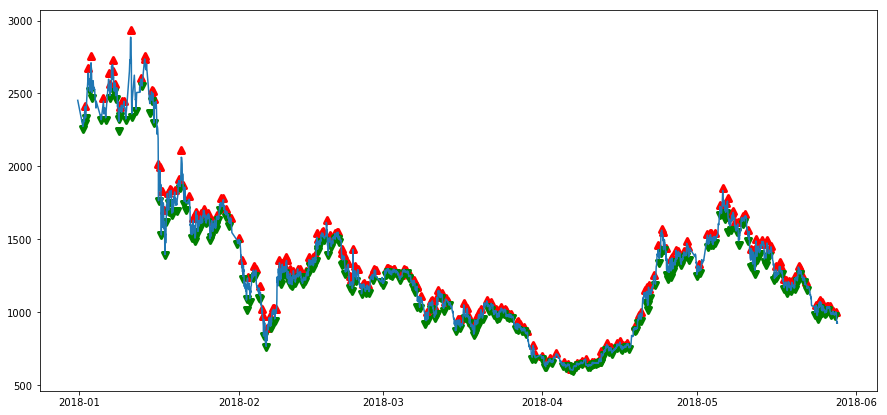

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7))
plt.plot(data1H['close'])
plt.scatter(list(high_dict.keys()), list(high_dict.values()), c='r', marker='^', linewidths=3)
plt.scatter(list(low_dict.keys()), list(low_dict.values()), c='g', marker='v', linewidths=3)
plt.show()

## 各种形态的计算条件是什么？
1. 三角形
    - 扩散三角形

        Top:
        - P1=highest
        - P1< P3< P5
        - P2 > P4
        
    - 收敛三角形
        Top:
        - P1=highest
        - P1> P3> P5
        - P2 < P4

2. 矩形
    Top:
    - P1=highest
    - P1,P3,P5 < (P1+P3+P5)/3*1.01
    - P1,P3,P5 > (P1+P3+P5)/3*0.99
    - P2,P4 < (P2+P4)/2*1.01

3. 头肩底
    - P1=Lowest
    - P3< P1, P3< P5
    - P1, P5 < (P1+P5)/2*1.01
    - P2, P4 < (P2+P4)/2*1.01

In [11]:
# 生成DataFrame处理
highest_series = pd.Series(list(high_dict.values()), index=list(high_dict.keys()))
lowest_series = pd.Series(list(low_dict.values()), index=list(low_dict.keys()))

data1H['highest'] = highest_series
data1H['lowest'] = lowest_series

In [12]:
point = pd.concat([data1H[['highest']], data1H['lowest']], axis=1).dropna(how='all')

In [13]:
def gap_index(multi_series):
    last = multi_series.index[0]
    
    for index in multi_series.index[1:]:
        if index[1] == last[1]:
            if index[1] == 'lowest':
                if multi_series.loc[index] < multi_series.loc[last]:
                    last = index
            else:
                if multi_series.loc[index] > multi_series.loc[last]:
                    last = index
                
        else:
            out = (last[0], last[1])
            last = index
            yield out

In [14]:
point_s = point.stack()

In [15]:
list(gap_index(point_s))

[(Timestamp('2018-01-01 17:00:00'), 'lowest'),
 (Timestamp('2018-01-02 02:00:00'), 'highest'),
 (Timestamp('2018-01-02 05:00:00'), 'lowest'),
 (Timestamp('2018-01-02 17:00:00'), 'highest'),
 (Timestamp('2018-01-03 02:00:00'), 'lowest'),
 (Timestamp('2018-01-03 06:00:00'), 'highest'),
 (Timestamp('2018-01-05 06:00:00'), 'lowest'),
 (Timestamp('2018-01-05 16:00:00'), 'highest'),
 (Timestamp('2018-01-06 04:00:00'), 'lowest'),
 (Timestamp('2018-01-06 16:00:00'), 'highest'),
 (Timestamp('2018-01-06 23:00:00'), 'lowest'),
 (Timestamp('2018-01-07 11:00:00'), 'highest'),
 (Timestamp('2018-01-07 18:00:00'), 'lowest'),
 (Timestamp('2018-01-07 23:00:00'), 'highest'),
 (Timestamp('2018-01-08 15:00:00'), 'lowest'),
 (Timestamp('2018-01-08 21:00:00'), 'highest'),
 (Timestamp('2018-01-08 23:00:00'), 'lowest'),
 (Timestamp('2018-01-09 16:00:00'), 'highest'),
 (Timestamp('2018-01-09 23:00:00'), 'lowest'),
 (Timestamp('2018-01-10 23:00:00'), 'highest'),
 (Timestamp('2018-01-11 04:00:00'), 'lowest'),
 (T

In [16]:
P_result = point_s.loc[list(gap_index(point_s))]

In [17]:
# P_result

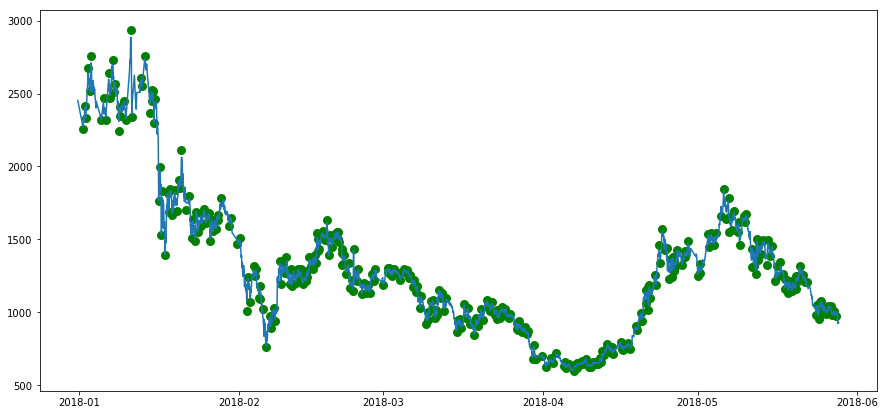

In [18]:
times = list(map(lambda index: index[0], P_result.index))

plt.figure(figsize=(15, 7))
plt.plot(data1H['close'])
plt.scatter(times, P_result.values, c='g', marker='o', linewidths=3)
plt.show()

## 收敛三角形 Top:

P1=lowest

P1< P3< P5

P2 > P4

In [19]:
def pattern_point(MI):
    # 找到三角形最后的一个点
    l=[]
    for i in range(5, len(MI)):
        T = MI.iloc[i-5: i]
        if Triangle_pattern(T):
            l.append(i)
    return MI[l]

def pattern_chart(MI):
    for i in range(5, len(MI)):
        T = MI.iloc[i-5: i]
        if Triangle_pattern(T):
            yield T

def Triangle_pattern(df):
    # 找出三角形所有点
    if df.index.labels[1][0] == 1:
        if (df.iloc[0]<df.iloc[2]) and (df.iloc[2]<df.iloc[4]):
            if df.iloc[1]>df.iloc[3]:
                return True

Signal_df = pattern_point(P_result)
Triangle = pd.concat(list(pattern_chart(P_result)))

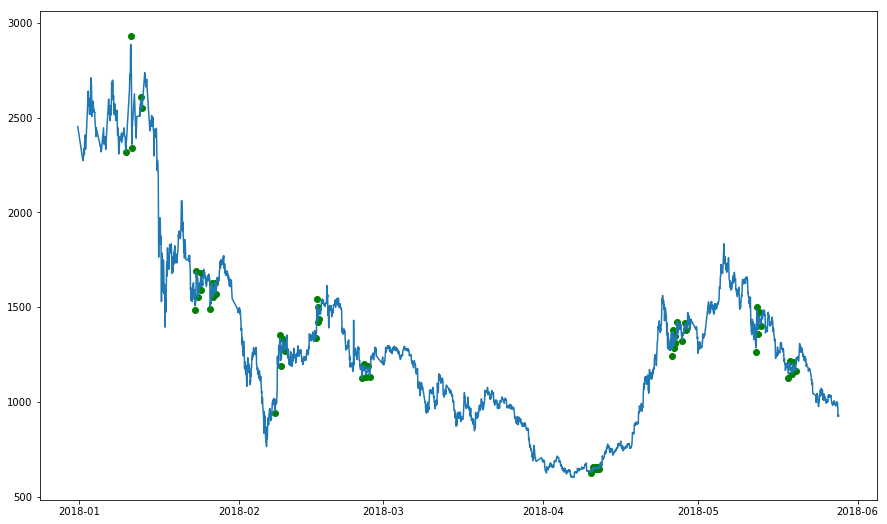

In [20]:
time_triangle = list(map(lambda index: index[0], Triangle.index))
# time_triangle
plt.figure(figsize=(15, 9))
plt.plot(data1H['close'])
plt.scatter(time_triangle, Triangle.values, c='g', marker='o', linewidths=1)
plt.show()

In [21]:
Signal_df = Signal_df.unstack()

In [22]:
Signal_df['time'] = Signal_df.index

## 找到形态点

In [23]:
Signal_df.index = Signal_df['time'].apply(lambda x:int(x.strftime(format="%Y-%m-%d %H:%M:%S").replace("-","").replace(":","").replace(" ","")))
Signal_df.pop('time')

time
20180113160000   2018-01-13 16:00:00
20180125030000   2018-01-25 03:00:00
20180127200000   2018-01-27 20:00:00
20180210030000   2018-02-10 03:00:00
20180217080000   2018-02-17 08:00:00
20180226210000   2018-02-26 21:00:00
20180411130000   2018-04-11 13:00:00
20180412030000   2018-04-12 03:00:00
20180426230000   2018-04-26 23:00:00
20180429020000   2018-04-29 02:00:00
20180513170000   2018-05-13 17:00:00
20180520040000   2018-05-20 04:00:00
Name: time, dtype: datetime64[ns]

In [26]:
data_append = data1H.copy()
data_append['time'] = data_append.index
data_append.index = data_append['time'].apply(lambda x:int(x.strftime(format="%Y-%m-%d %H:%M:%S").replace("-","").replace(":","").replace(" ","")))

In [28]:
data_append['pattern'] = Signal_df['highest']

In [30]:
data_signal = data_append[['close', 'pattern']]

## 建立阻力支撑均线与有效阻力支撑向前填充20个Bar

In [36]:
data_signal['upperBand'] = 1.01*data_signal['pattern']
data_signal['lowerBand'] = 0.99*data_signal['pattern']

In [37]:
data_signal = data_signal.fillna(method='ffill',limit=20)

In [38]:
data_signal['MA'] = ta.abstract.MA(data_signal,40, prices='close')

In [39]:
data_signal['shift_close'] = data_signal['close'].shift(1)
data_signal['shift_upperBand'] = data_signal['upperBand'].shift(1)
data_signal['shift_lowerBand'] = data_signal['lowerBand'].shift(1)

## 判断进场条件
1.Price>MA：

    突破上轨 and 下破下轨后向上突破下轨
    

2.Price<MA：

    突破下轨 and 上破上轨后向下突破上轨

In [40]:
singal_dict = {}
for i, v in data_signal.iterrows():
    if v.pattern:
        if (v.close>v.MA):
            if (v.close >= v.upperBand) or ((v.shift_close <= v.shift_lowerBand) and (v.close >= v.lowerBand)):
                v['signal']=2
                singal_dict[i]=v
        elif (v.close<v.MA):
            if (v.close <= v.lowerBand) or ((v.shift_close >= v.shift_upperBand) and (v.close <= v.upperBand)):
                v['signal']=-2
                singal_dict[i]=v

In [41]:
# singal_dict

In [42]:
data_signal['singal'] = pd.DataFrame(singal_dict).T.signal

In [43]:
patternSignal = data_signal.singal

In [44]:
patternSignal = patternSignal.fillna(0)

## 将信号添加进DV

In [45]:
dv.append_df(patternSignal, 'patternSignal')

In [46]:
# patternSignal.dropna()

In [47]:
long = dv.add_formula('long', 'If((patternSignal==2) && (Delay(patternSignal,1)!=2),2,0)', add_data=True)
short = dv.add_formula('short', 'If((patternSignal==-2) && (Delay(patternSignal,1)!=-2),-2,0)', add_data=True)

close_long = dv.add_formula("closeLong","If(short==-2,1,0)", add_data=True)
close_short = dv.add_formula("closeShort","If(long==2,-1,0)", add_data=True)

In [54]:
from jaqs_fxdayu.research import TimingDigger

td = TimingDigger(output_folder=".", output_format='pdf',signal_name='Pattern')

def TimingSignal(mhp=None,sl=None,sp=None):
    # step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称


    #多空分别计算一遍 输出汇总结果
    td.process_signal(
        enter_signal=dv.get_ts("long"),
        exit_signal=dv.get_ts("closeLong"),
        sig_type="long",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(
        enter_signal=dv.get_ts("short"),
        exit_signal=dv.get_ts("closeShort"),
        sig_type="short",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )
TimingSignal(1000, 0.1)

Nan Data Count (should be zero) : 0;  Percentage of effective data: 1%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 0%


In [55]:
td.create_event_report(sig_type="long_short",
                       by_symbol=True)

Figure saved: E:\2018_Course\1_Research2Strategy\Pattern/long_short_entry_exit_position/btc_usdt.pdf
*****-Summary-*****
Event Analysis
                       win    loss     all
t-stat               3.970  -7.343   1.991
p-value              0.003   0.000   0.056
mean                 0.622  -0.078   0.163
std                  0.470   0.045   0.434
info_ratio           1.323  -1.731   0.376
skewness            -0.172  -0.271   1.490
kurtosis            -1.739  -0.631   0.500
pct5                 0.001  -0.133  -0.125
pct25                0.148  -0.109  -0.102
pct50                0.705  -0.078  -0.033
pct75                1.076  -0.036   0.094
pct95                1.133  -0.018   1.108
occurance           10.000  19.000  29.000
win_ratio              NaN     NaN   0.345
win_mean/loss_mean     NaN     NaN   7.955


## 如何将形态编写成策略？
选出处于高位收敛三角形的股票
1. 读取每一只股票过去五天的高低点
2. 对这些高低点进行条件判断
3. 满足条件的股票返回True

## 作业
熟悉MultiIndex的应用，并且还一直股票来寻找形态。